In [1]:
from brian2 import *
import pandas as pd
import sympy
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import dh_parameters as dp

%matplotlib notebook

from importlib import reload
reload(dp);

In [2]:
def generate_periodic_spike_times(rate, start_time, stop_time):
    ###unitless but do it in seconds to make it easy
    duration = stop_time - start_time
    num_spikes = np.floor(duration * rate)
    true_duration = num_spikes / rate
    spike_times = np.linspace(start_time, start_time + true_duration, num_spikes)
    return spike_times

def connect_neuron_groups(pre_group, post_group,
                          conductance_name = 'e',
                          p = 1, 
                          w_mu = 1 * nS, 
                          w_sigma = 0.1 * nS):
    on_pre_equation = 'g_' + conductance_name + '_post += w'
    S = Synapses(pre_group, post_group,model = 'w : siemens',
                             on_pre = on_pre_equation)
    S.connect(p = p)
    S.w =  w_mu + w_sigma * randn(S.w.shape[0])
    S.w['w < 0 * nS'] = 0 * nS
    return S

class neuron_group_constructor():
        
    def __init__(self):
        self.params = {}
    
    def select_cell_type(self, cell_type):
        self.params = dp.get_neuron_params(cell_type)
        return self
    
    def return_ta(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        I_ex_array = np.tile(I_ex, (tb.shape[0],1))
        self.I_ex = TimedArray(I_ex_array,sim_dt)
        return I_ex_array
    
    def initialize_external_current_array(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        self.I_ex = np.tile(I_ex, (tb.shape[0],1)) 
        return self

    def generate_neuron_group(self, initialize = True):
        
        N = self.params['N']
        self.initialize_external_current_array()
        
        # create neuron group and add params to namespace
        NG = NeuronGroup(N, model=self.params['model_eq'],
                     threshold=self.params['threshold_eq'],
                     reset=self.params['reset_eq'],
                     refractory=self.params['refractory_eq'],
                     method = 'euler')

        for key, value in self.params['intrinsics'].items():
            NG.namespace[key] = value
  
        # constant parameters that vary between neurons in this group
        g_l_mu = self.params['intrinsics']['g_l_mu']
        g_l_sigma = self.params['intrinsics']['g_l_sigma']
        NG.g_l = (g_l_mu + g_l_sigma * randn(N))
        
        if initialize:
            NG.g_i = '0 * nS'
            NG.g_e = '0 * nS'
            NG.v = self.params['intrinsics']['E_l']   
            if self.params['dynamics'] == 'adex':
                 NG.u = '0 * pA'
        
        return NG, self.params.copy(), self.I_ex
    
    ## projection neurons
    

        
    
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,duration,sim_dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *sim_dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind
    
class afferent_group():
    
    def __init__(self):
        self.params = {}
        self.time_bins = np.arange(0,duration,sim_dt)
        self.psth = np.zeros(self.time_bins.shape)
        
    def select_cell_type(self, cell_type):
        self.params = dp.get_afferent_params(cell_type)
        return self
        
    def add_stim(self, stim_type, start_time,**kwargs):
        
        if stim_type == 'electrical':
            sigma = self.params['stim_electrical_sigma']
            N = self.params['N']
            rates = self.params['stim_electrical_rates']
            if not isinstance(rates, (list, tuple, np.ndarray)):
                rates = np.ones(N)*rates
            
            stim_response, time_bins = gaussian_psth(start_time + self.params['delay'], sigma)
            self.psth += stim_response
            self.spikes, self.ind = generate_population_spikes(self.psth,rates)
        
    def generate_afferent_group(self):
        return SpikeGeneratorGroup(self.params['N'], self.ind, self.spikes), self.params.copy()
    
    
def initialize_I_ex(NG, I_ex):
    NG.namespace['I_ex'] = TimedArray(I_ex,sim_dt)
    
def add_step(I_ex, start, stop, amplitude):
    tb = np.arange(0,duration,sim_dt)
    window = (tb > start) & (tb < stop)
    I_ex[window,:] = amplitude
    return I_ex

def add_step_ind(I_ex, start, stop, amplitude, ind):
    tb = np.arange(0,duration,sim_dt)
    window = (tb > start) & (tb < stop)
    I_ex[window,ind] = amplitude
    return I_ex       

In [3]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [4]:
################################################################################
# Model parameters
################################################################################
### General parameters
duration = 1.5*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
defaultclock.dt = sim_dt
tb = np.zeros(np.arange(0,duration,sim_dt).shape)

In [60]:
currents = (np.arange(55.0,130.,5.)) * pA

In [6]:
currents

array([ 60.,  80., 100., 120.]) * pamp

In [7]:
intrinsics['C_m'] * (1/intrinsics['g_l_mu'])

NameError: name 'intrinsics' is not defined

In [68]:
#tonic
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = 40 * pF
intrinsics['g_l_mu'] = 2 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = 40 * pA
intrinsics['alpha'] = 0 * nS
intrinsics['tau_u'] = 50*ms
intrinsics['V_r'] = -55*mV
intrinsics['V_th'] = -40*mV
intrinsics['Delta_t'] = 2*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 250 * ms, 1250 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [24]:
#adapting
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = 40 * pF
intrinsics['g_l_mu'] = 2 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = 7 * pA
intrinsics['alpha'] = 0.5 * nS
intrinsics['tau_u'] = 100*ms
intrinsics['V_r'] = -55*mV
intrinsics['V_th'] = -50*mV
intrinsics['Delta_t'] = 2*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [69]:
net = Network(ngs,states,spikes)
# net.add()
net.store()
net.run(duration, report = 'text', profile = True)
make_spikes_pretty(spikes,states,spike_height = 0.040)

vm = [states.v[i,:] for i in range(ngs.N)]
vm = np.concatenate(vm)

tb = [states.t + i * 2 * second for i in range(ngs.N)]
tb = np.concatenate(tb)

WARNING    "i" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 14. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s


(1.5, 7.9, -87.59745720720798, 46.07606939081943)

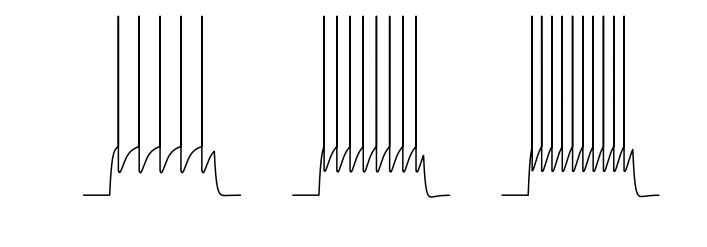

In [70]:
f,ax = plt.subplots(figsize = (12,4))
for i in range(ngs.N):
    ax.plot(states.t + i * 2 * second,states.v[i,:]/mV,'k')
ax.set_xlim((1.5,7.9))
plt.axis('off')
# plt.tight_layout()
# f.savefig('/Users/nakaa1/Documents/Presentations/group_meeting_20190329/bursting.png',dpi = 300)

In [33]:
#transient
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = 5 * pF
intrinsics['g_l_mu'] = 2 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = 10 * pA
intrinsics['alpha'] = 1. * nS
intrinsics['tau_u'] = 120 * ms
intrinsics['V_r'] = -60 * mV
intrinsics['V_th'] = -40 * mV
intrinsics['Delta_t'] = 2*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [97]:
#delayed
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = 40 * pF
intrinsics['g_l_mu'] = 2 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = -0.5 * pA
intrinsics['alpha'] = -1 * nS
intrinsics['tau_u'] = 200*ms
intrinsics['V_r'] = -55*mV
intrinsics['V_th'] = -50*mV
intrinsics['Delta_t'] = 2*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [110]:
intrinsics['C_m']/intrinsics['g_l_mu']

5. * msecond

In [122]:
#bursting
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = 10 * pF
intrinsics['g_l_mu'] = 2 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = 7 * pA
intrinsics['alpha'] = -0.5 * nS
intrinsics['tau_u'] = 100*ms
intrinsics['V_r'] = -46*mV
intrinsics['V_th'] = -50*mV
intrinsics['Delta_t'] = 2*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [56]:
net = Network(ngs,states,spikes)
# net.add()
net.store()
net.run(duration, report = 'text', profile = True)
make_spikes_pretty(spikes,states,spike_height = 0.040)

vm = [states.v[i,:] for i in range(ngs.N)]
vm = np.concatenate(vm)

WARNING    "t" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value array([], dtype=float64) * second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s


In [59]:
sns.set_style('dark')
sns.set_context('talk')

<IPython.core.display.Javascript object>


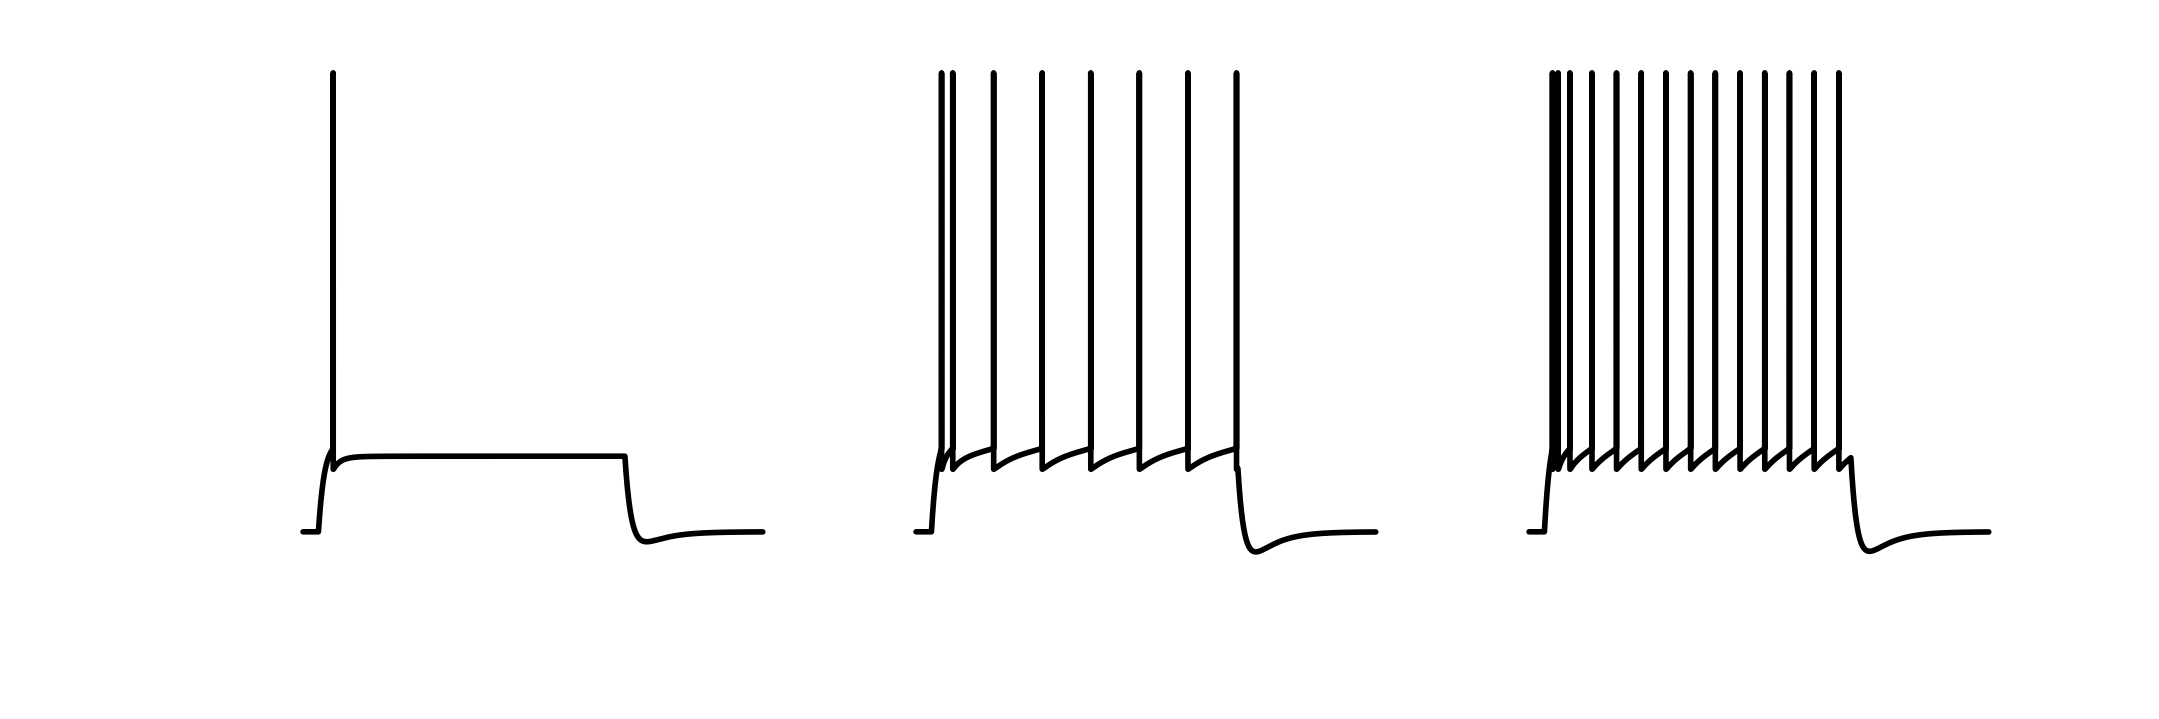

In [22]:
#generate training data
currents = np.concatenate((np.array([-100.0,-50]),np.arange(0.0,200.0,5.0))) * pA

gt = [30,1.6,4,-0.5,30,-55,2]
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = gt[0] * pF
intrinsics['g_l_mu'] = gt[1] * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = gt[2] * pA
intrinsics['alpha'] = gt[3] * nS
intrinsics['tau_u'] = gt[4]*ms
intrinsics['V_r'] = gt[5]*mV
intrinsics['V_th'] = -40*mV
intrinsics['Delta_t'] = gt[6]*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [8]:
vrtb = np.arange(0*ms,400*ms,sim_dt )
tau_vr = 80 * ms
van_rossum_kernel = np.heaviside(vrtb,1)*np.exp(-vrtb/tau_vr)

def van_rossum_conv(spikes, timebase, van_rossum_kernel):
    spike_trains = spikes.spike_trains()
    vrs = []
    for n, spike_train in spike_trains.items():
        this_spike_train = tb.copy()
        for spike_time in (spike_train/sim_dt):
            this_spike_train[int(spike_time)]=1
        vrs.append(np.convolve(this_spike_train,van_rossum_kernel,'same'))
    return np.stack(vrs)

WARNING    /Users/nakaa1/anaconda3/envs/brian/lib/python3.6/site-packages/brian2/units/fundamentalunits.py:1025: UserWarning: Unknown ufunc 'heaviside' in __array_prepare__
  warn("Unknown ufunc '%s' in __array_prepare__" % uf.__name__)
 [py.warnings]
WARNING    /Users/nakaa1/anaconda3/envs/brian/lib/python3.6/site-packages/brian2/units/fundamentalunits.py:1060: UserWarning: Unknown ufunc 'heaviside' in __array_wrap__
  warn("Unknown ufunc '%s' in __array_wrap__" % uf.__name__)
 [py.warnings]


In [23]:
net = Network(ngs,states,spikes)
# net.add()
net.store()

In [24]:
net.run(duration, report = 'text', profile = True)

Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s


In [25]:
tb = np.zeros(np.arange(0,duration,sim_dt).shape)
train_van_rossum = van_rossum_conv(spikes, tb, van_rossum_kernel)
train_v = states.v_.copy()

In [493]:
# try to fit
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = 40 * pF
intrinsics['g_l_mu'] = 2 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = 7 * pA
intrinsics['alpha'] = 0.5 * nS
intrinsics['tau_u'] = 100*ms
intrinsics['V_r'] = -55*mV
intrinsics['V_th'] = -40*mV
intrinsics['Delta_t'] = 2*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [494]:
net = Network(ngs,states,spikes)
# net.add()
net.store()

In [495]:
net.run(duration, report = 'text', profile = True)

Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s


In [20]:
fit_van_rossum = van_rossum_conv(spikes, tb, van_rossum_kernel)
fit_v = states.v_.copy()

<IPython.core.display.Javascript object>


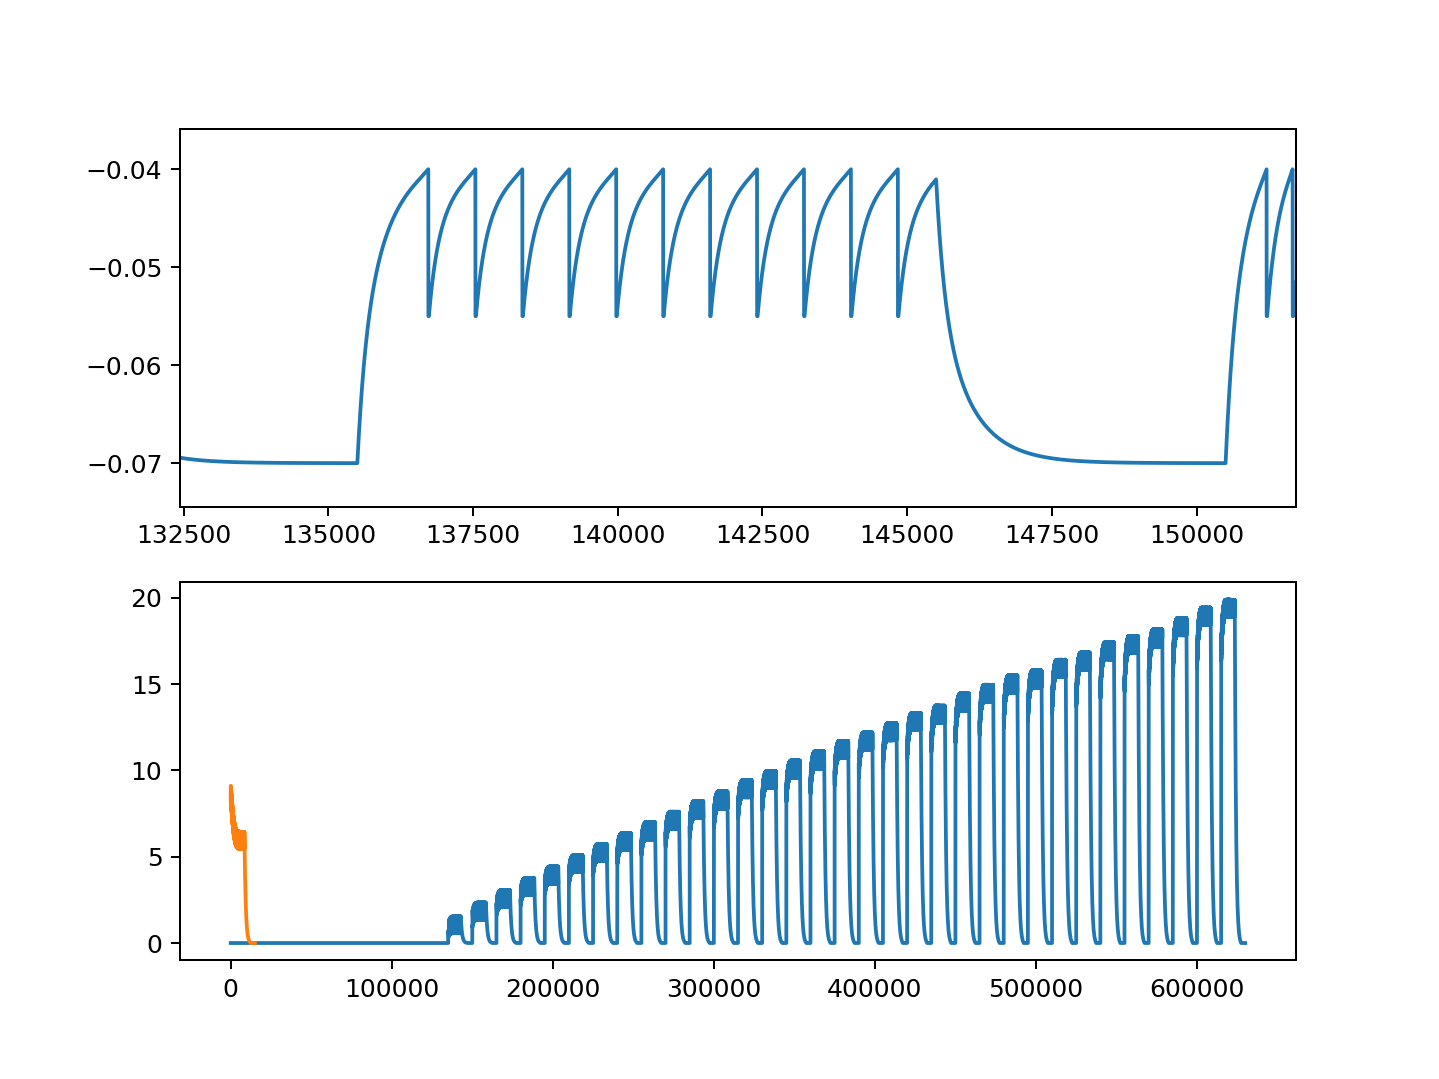

In [28]:
f,ax = plt.subplots(2,1,figsize = (8,6))
ax[0].plot(train_v.flatten())
ax[0].plot(fit_v.flatten())
ax[1].plot(train_van_rossum.flatten())
ax[1].plot(fit_van_rossum.flatten())

In [9]:
def joint_cost(train_v,train_van_rossum,fit_v,fit_van_rossum, van_rossum_weight = 1):
    return (np.sum((train_v-fit_v)**2) + van_rossum_weight* np.sum((train_van_rossum-fit_van_rossum)**2)) ** 0.5

def van_rossum_cost(train_van_rossum,fit_van_rossum):
    return (np.sum((train_van_rossum-fit_van_rossum)**2)) ** 0.5

In [ ]:
joint_cost(train_v,train_van_rossum,fit_v,fit_van_rossum, van_rossum_weight = 1)

In [10]:
from scipy import optimize as op

In [11]:
def run_network(x, train_v, train_van_rossum):
    constructor = neuron_group_constructor().select_cell_type('i_gal')
    constructor.params['N'] = len(currents)
    intrinsics = constructor.params['intrinsics']
    intrinsics['E_l'] = - 70 * mV
    intrinsics['C_m'] = x[0] * pF
    intrinsics['g_l_mu'] = x[1] * nS
    intrinsics['g_l_sigma'] = 0 * nS
    intrinsics['b'] = x[2] * pA
    intrinsics['alpha'] = x[3] * nS
    intrinsics['tau_u'] = x[4] *ms
    intrinsics['V_r'] = x[5] *mV
    intrinsics['V_th'] = -40*mV
    intrinsics['Delta_t'] = x[6] *mV
    constructor.params['intrinsics'] = intrinsics
    ngs,params,i_ex = constructor.generate_neuron_group()
    states= StateMonitor(ngs, ['v'], record=True)
    spikes= SpikeMonitor(ngs, record=True)
    for n,current in enumerate(currents):
        i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
    initialize_I_ex(ngs, i_ex)
    net = Network(ngs,states,spikes)
    net.run(duration, report = 'text', profile = True)
    fit_van_rossum = van_rossum_conv(spikes, tb, van_rossum_kernel)
    fit_v = states.v_.copy()
    return joint_cost(train_v,train_van_rossum,fit_v,fit_van_rossum, van_rossum_weight = 1)

In [ ]:
res

In [ ]:
bounds = [(0,100),(0,10),(0,20),(-2,2),(3,200),(-70,-51),(0,3)]
res = op.differential_evolution(func = run_network,bounds = bounds,args = (train_v, train_van_rossum),
                                maxiter = 3)

In [ ]:
res = op.differential_evolution(func = run_network,bounds = bounds,args = (train_v, train_van_rossum),
                                maxiter = 3)

In [ ]:
res

In [8]:
import csv
thing = []
with open('/Users/nakaa1/Documents/digitize/Prescott2002/top_spikes.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        thing.append(row)
        
x = []
y = []
for i in thing[1:]:
    x.append(float(i[0]))
    y.append(float(i[1]))
    
x = np.array(x)
y = np.array(y)
x -= x[0]
y -= y[0]    

In [9]:
y = y[1:]
x = x[1:]

In [14]:
tb = np.arange(0,duration,sim_dt)

In [12]:
def van_rossum_conv_data(spikes, timebase, van_rossum_kernel):
    this_spike_train = np.zeros(timebase.shape)
    for spike_time in (spikes/sim_dt):
        this_spike_train[int(spike_time)]=1
    return np.convolve(this_spike_train,van_rossum_kernel,'same')

train_van_rossum = np.array(van_rossum_conv_data(x*ms, tb, van_rossum_kernel))

NameError: name 'x' is not defined

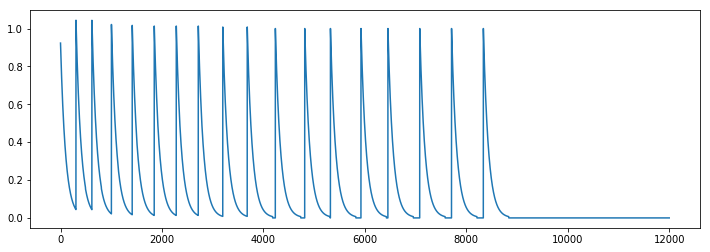

In [16]:
f,ax = plt.subplots(1,1,figsize = (12,4))
# ax.plot(x,y,'.');
ax.plot(train_van_rossum);
# ax.set_xlim((150,250))

In [ ]:
1/(700 * Mohm)

In [13]:
#guess
currents = [250] * pA

gt = [150,0.5,50,-60,15]
constructor = neuron_group_constructor().select_cell_type('i_gal').adex_g_intrinsics()
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 60 * mV
intrinsics['C_m'] = 60 * pF
intrinsics['g_l_mu'] = 1.4 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = gt[0] * pA
intrinsics['alpha'] = gt[1] * nS
intrinsics['tau_u'] = gt[2]*ms
intrinsics['V_r'] = gt[3]*mV
intrinsics['V_th'] = -40*mV
intrinsics['Delta_t'] = gt[4]*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 0 * ms, 1000 * ms, current, n)
initialize_I_ex(ngs, i_ex)

AttributeError: 'neuron_group_constructor' object has no attribute 'adex_g_intrinsics'

In [18]:
net = Network(ngs,states,spikes)
# net.add()
net.store()
net.run(duration)

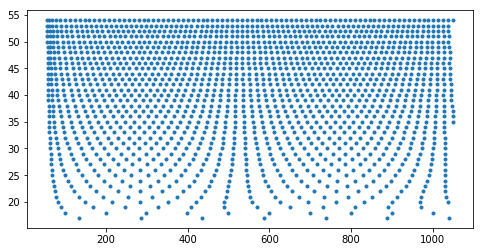

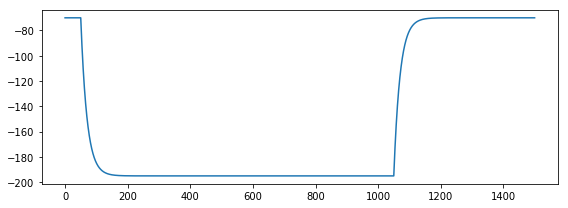

In [14]:
f,ax = plt.subplots(1,1,figsize = (8,4))
ax.plot(spikes.t/ms, spikes.i,'.');

f,ax = plt.subplots(1,1,figsize = (8,3))
ax.plot(states.t/ms, states.v[0,:]/ms);
plt.tight_layout() 


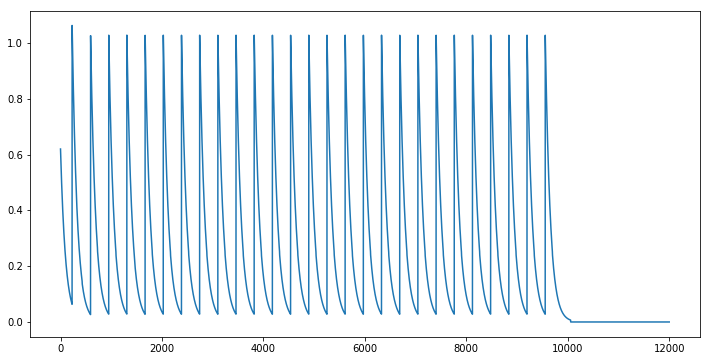

In [24]:
f,ax = plt.subplots(figsize = (12,6))

ax.plot(fit_van_rossum)

In [21]:
spikes.t_

<spikemonitor.t_: Quantity(array([0.0051, 0.0176, 0.0478, 0.0842, 0.12  , 0.1558, 0.1917, 0.2275,
       0.2634, 0.2992, 0.3351, 0.3709, 0.4068, 0.4426, 0.4785, 0.5143,
       0.5502, 0.586 , 0.6219, 0.6577, 0.6936, 0.7294, 0.7653, 0.8011,
       0.837 , 0.8728, 0.9087, 0.9445, 0.9804]))>

In [22]:
fit_van_rossum = van_rossum_conv_data(spikes.t, tb, van_rossum_kernel)

In [33]:
def run_network_vr_only(x, train_van_rossum):
    constructor = neuron_group_constructor().select_cell_type('i_gal')
    constructor.params['N'] = len(currents)
    intrinsics = constructor.params['intrinsics']
    intrinsics['E_l'] = - 60 * mV
    intrinsics['C_m'] = 60 * pF
    intrinsics['g_l_mu'] = 1.4 * nS
    intrinsics['g_l_sigma'] = 0 * nS
    intrinsics['b'] = x[0] * pA
    intrinsics['alpha'] = x[1] * nS
    intrinsics['tau_u'] = x[2] *ms
    intrinsics['V_r'] = x[3] *mV
    intrinsics['V_th'] = -40*mV
    intrinsics['Delta_t'] = x[4] *mV
    constructor.params['intrinsics'] = intrinsics
    ngs,params,i_ex = constructor.generate_neuron_group()
    states= StateMonitor(ngs, ['v'], record=True)
    spikes= SpikeMonitor(ngs, record=True)
    for n,current in enumerate(currents):
        i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
    initialize_I_ex(ngs, i_ex)
    net = Network(ngs,states,spikes)
    net.run(duration, report = 'text', profile = True)
    fit_van_rossum = van_rossum_conv_data(spikes.t, tb, van_rossum_kernel)
    fit_v = states.v_.copy()
    return van_rossum_cost(train_van_rossum,fit_van_rossum)

In [30]:
train_van_rossum.shape

(12000,)

In [56]:
bounds = [(-100,300),(-2,2),(1,200),(-70,-41),(0,10)]
res = op.differential_evolution(func = run_network_vr_only,bounds = bounds,args = [train_van_rossum],
                                maxiter = 30)

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starti

1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100

1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%)

1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 7s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 2s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 2s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 4s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 2s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 2s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) sim

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting s

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) sim

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starti

1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.2 s
1.2 (100%) simulated in < 1s
Star

In [57]:
res

     fun: 28.071336325131007
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 2331
     nit: 30
 success: False
       x: array([173.47511152,   0.94479584, 168.56065815, -42.72622831,
         6.28001131])

In [58]:

gt = res.x
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 60 * mV
intrinsics['C_m'] = 60 * pF
intrinsics['g_l_mu'] = 1.4 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = gt[0] * pA
intrinsics['alpha'] = gt[1] * nS
intrinsics['tau_u'] = gt[2]*ms
intrinsics['V_r'] = gt[3]*mV
intrinsics['V_th'] = -40*mV
intrinsics['Delta_t'] = gt[4]*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 0 * ms, 1000 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [59]:
net = Network(ngs,states,spikes)
# net.add()
net.store()
net.run(duration)

<IPython.core.display.Javascript object>


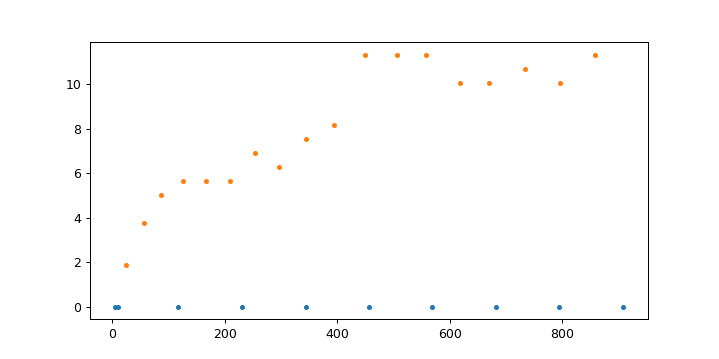

<IPython.core.display.Javascript object>


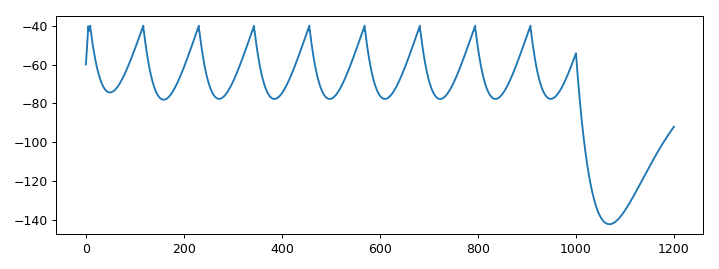

In [61]:
f,ax = plt.subplots(1,1,figsize = (8,4))
ax.plot(spikes.t/ms, spikes.i,'.');
ax.plot(x,y,'.');

f,ax = plt.subplots(1,1,figsize = (8,3))
ax.plot(states.t/ms, states.v[0,:]/ms);
plt.tight_layout() 

In [370]:
import pyabf as ab
abf = ab.ABF("/Volumes/brain_slice/Naka/Data/confocal_ephys/2018_11_02/2018_11_03_d/2018_11_02_0037.abf")
d_times = []
d_currents = []
d_v = []
for sweepNumber in abf.sweepList:
    abf.setSweep(sweepNumber,channel = 0)
    d_times.append(abf.sweepX)
    d_currents.append(abf.sweepC)
    d_v.append(abf.sweepY)
    
d_vm = []
d_spks = []
d_vr =[]
for this_v in d_v:
    v = this_v.copy()
    v = signal.decimate(signal.decimate(v,4),5)
    spks,pkh = signal.find_peaks(v, height = -20)
    d_spks.append(spks)
    d_vr.append(van_rossum_conv_data(spks*sim_dt, tb, van_rossum_kernel))
    v[v>-40] = -40
    d_vm.append(v/1000) 
    
d_vm = np.array(d_vm)
d_vr = np.array(d_vr)

WARNING    /Users/nakaa1/anaconda3/envs/brian/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 [py.warnings]
  b = a[a_slice]

WARNING    /Users/nakaa1/anaconda3/envs/brian/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
 [py.warnings]
  return y[sl]



In [70]:
d_c =[]
for d_current in d_currents:
    d_c.append(max(d_current))

In [72]:
from scipy import signal

<IPython.core.display.Javascript object>


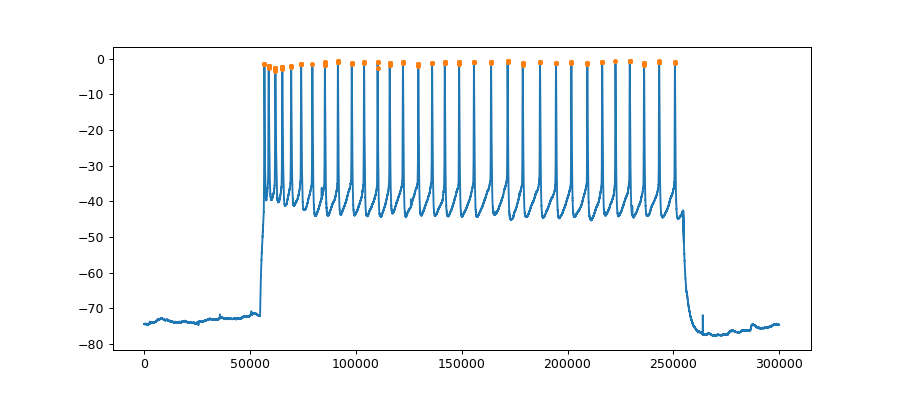

In [104]:
plt.plot(d_v[18])
# pks,pkh = signal.find_peaks(d_v[18], height = -20)
# # plt.plot(pks,d_v[18][pks])
# pkh = pkh['peak_heights']
plt.plot(pks,pkh,'.')

<IPython.core.display.Javascript object>


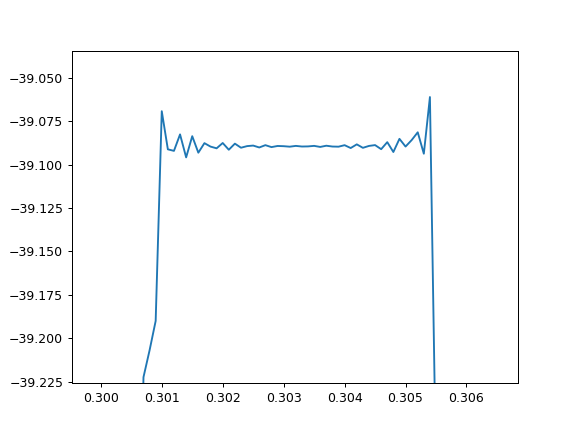

In [89]:
f,ax = plt.subplots()
ax.plot(np.arange(0,1.5 * second,d_dt),d_vm[12])

In [259]:
d_times[0][1]* second

5. * usecond

<IPython.core.display.Javascript object>


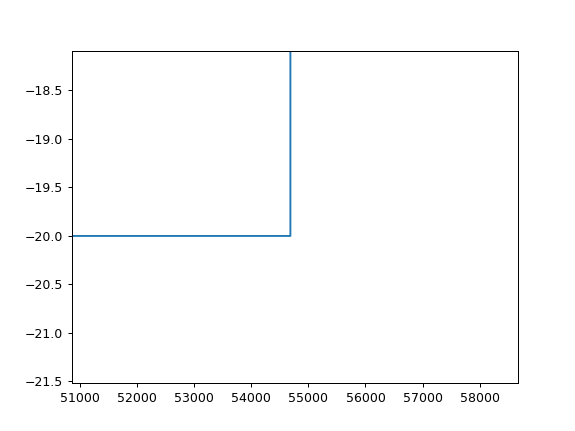

In [253]:
f,ax = plt.subplots()
ax.plot(d_current)

In [257]:
54686 * 5e-06 * second

273.43 * msecond

In [505]:
#guess
currents = (np.array(d_c) + 20) * pA

gt = [30,25,0.5,40,-50,-40,2]
gt =res.x
# gt = bfgs
constructor = neuron_group_constructor().select_cell_type('i_gal')
constructor.params['N'] = len(currents)
intrinsics = constructor.params['intrinsics']
intrinsics['E_l'] = - 70 * mV
intrinsics['C_m'] = gt[0] * pF
intrinsics['g_l_mu'] = 1.6 * nS
intrinsics['g_l_sigma'] = 0 * nS
intrinsics['b'] = gt[1] * pA
intrinsics['alpha'] = gt[2] * nS
intrinsics['tau_u'] = gt[3]*ms
intrinsics['V_r'] = gt[4]*mV
intrinsics['V_th'] = gt[5]*mV
intrinsics['Delta_t'] = gt[6]*mV
constructor.params['intrinsics'] = intrinsics
ngs,params,i_ex = constructor.generate_neuron_group()
states= StateMonitor(ngs, ['v'], record=True)
spikes= SpikeMonitor(ngs, record=True)
for n,current in enumerate(currents):
    i_ex = add_step_ind(i_ex, 273.43 * ms, 1273.43 * ms, current, n)
initialize_I_ex(ngs, i_ex)

In [506]:
net = Network(ngs,states,spikes)
# net.add()
net.store()
net.run(duration)

<IPython.core.display.Javascript object>


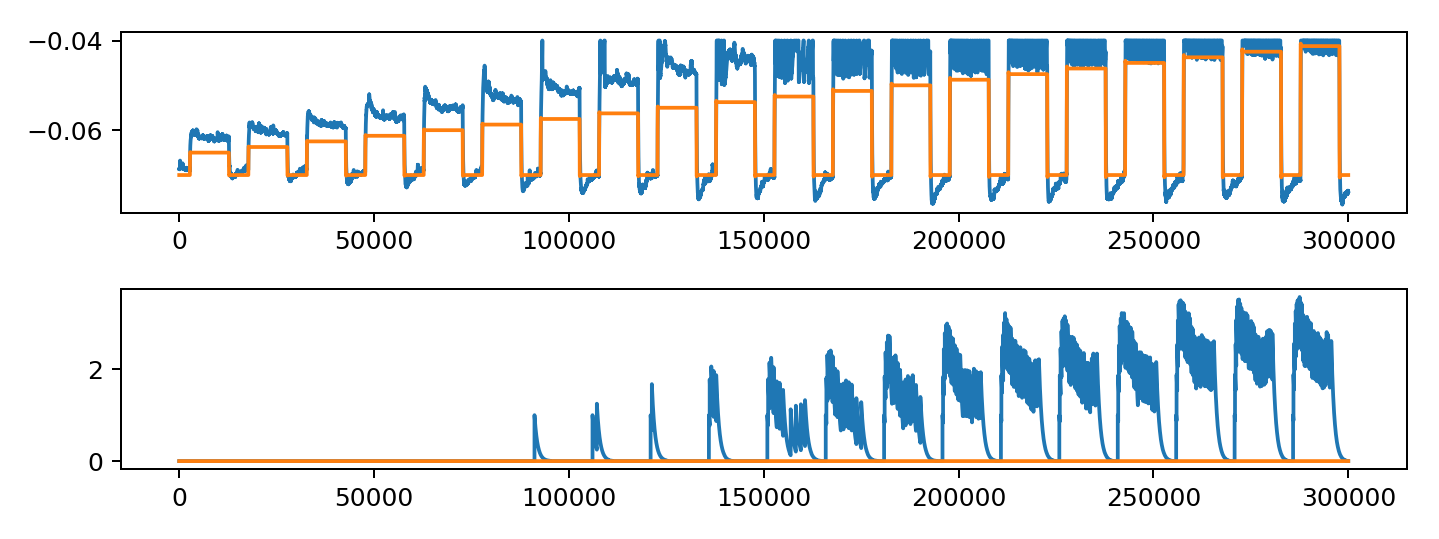

6266.868489182005

In [507]:
f,ax = plt.subplots(2,1,figsize = (8,3))
ax[0].plot(d_vm.flatten());
ax[0].plot(states.v_.flatten());
ax[1].plot(d_vr.flatten());
ax[1].plot(van_rossum_conv(spikes, tb, van_rossum_kernel).flatten())
plt.tight_layout() 

joint_cost(states.v_,van_rossum_conv(spikes, tb, van_rossum_kernel),d_vm,d_vr, van_rossum_weight = 100)



In [509]:
def run_network(x, train_v, train_van_rossum):
    constructor = neuron_group_constructor().select_cell_type('i_gal')
    constructor.params['N'] = len(currents)
    intrinsics = constructor.params['intrinsics']
    intrinsics['E_l'] = - 70 * mV
    intrinsics['C_m'] = x[0] * pF
    intrinsics['g_l_mu'] = 1.6 * nS
    intrinsics['g_l_sigma'] = 0 * nS
    intrinsics['b'] = x[1] * pA
    intrinsics['alpha'] = x[2] * nS
    intrinsics['tau_u'] = x[3] *ms
    intrinsics['V_r'] = x[4] *mV
    intrinsics['V_th'] = -40*mV
    intrinsics['Delta_t'] = x[5] *mV
    constructor.params['intrinsics'] = intrinsics
    ngs,params,i_ex = constructor.generate_neuron_group()
    states= StateMonitor(ngs, ['v'], record=True)
    spikes= SpikeMonitor(ngs, record=True)
    for n,current in enumerate(currents):
        i_ex = add_step_ind(i_ex, 50 * ms, 1050 * ms, current, n)
    initialize_I_ex(ngs, i_ex)
    net = Network(ngs,states,spikes)
    net.run(duration, report = 'text', profile = True)
    fit_van_rossum = van_rossum_conv(spikes, tb, van_rossum_kernel)
    fit_v = states.v_.copy()
    return joint_cost(train_v,train_van_rossum,fit_v,fit_van_rossum, van_rossum_weight = 1)

In [510]:
bounds = [(1,100),(0,100),(-2,2),(3,200),(-70,-41),(0.1,9)]
res = op.differential_evolution(func = run_network,bounds = bounds,args = (d_vm, d_vr),
                                maxiter = 1)

Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 4s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. 

1.5 (100%) simulated in 2s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 2s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 2s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
S

1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 

In [504]:
res

     fun: 626.7237009285981
     jac: array([-0.0001,  0.    , -0.0008, ...,  0.    ,  0.    ,  0.    ])
 message: 'Optimization terminated successfully.'
    nfev: 258
     nit: 1
 success: True
       x: array([  9.464 ,  22.9284,   2.3994, ...,  76.6039, -48.922 ,   1.1341])

In [337]:
init = [30,7,1,60,-45,-45,0.1]
bounds = [(10,100),(0,100),(-3,3),(3,200),(-70,-41),(-55,-35),(0,9)]
bfgs,f,d = op.fmin_l_bfgs_b(func = run_network, x0 = init, bounds = bounds,
                        args = (d_vm, d_vr),approx_grad = True, maxiter = 100,
                            iprint =0,factr = 10**9,callback = print)

Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starti

Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting s

1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 1.5 s
1.5 (100

In [338]:
bfgs

array([ 30.076 ,   7.3004,   2.2925, ..., -45.3869, -44.8468,   0.1   ])

In [347]:
d['grad']

array([-0.0002, -0.0011,  0.0025, ...,  0.0005, -0.0002,  0.    ])